In [95]:
from ortools.linear_solver import pywraplp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

In [ ]:
## DUMMY DEMO

# Create the mip solver with the SCIP backend.
solver = pywraplp.Solver.CreateSolver('SCIP')

## Define the variables, which (for now) are the # firefighters assigned to each county

# All county variables are non-negative integers
infinity = solver.infinity()
alameda = solver.IntVar(0.0, infinity, 'Alameda')
alpine = solver.IntVar(0.0, infinity, 'Alpine')
amador = solver.IntVar(0.0, infinity, 'Amador')
butte = solver.IntVar(0.0, infinity, 'Butte')
calaveras = solver.IntVar(0.0, infinity, 'Calaveras')

# All risk variables are non-negative floats
alameda_risk = 1.2
alpine_risk = 1.5
amador_risk = 0.3
butte_risk = 0.01
calaveras_risk = 0.01

## Define the contraints
# The total number of firefighters dispatched must not exceed 50 
solver.Add(alameda + alpine + amador + butte + calaveras <= 50)

## Define the objective function
# Maximize the total "risk addressed" by the firefighting resources available

county_list = [alameda, alpine, amador, butte, calaveras]
risk_list = [alameda_risk, alpine_risk, amador_risk, butte_risk, calaveras_risk]

# This function automatically does:
# alameda*alameda_risk + alpine*alpine_risk + amador*amador_risk + butte*butte_risk + calaveras*calaveras_risk
def buildObjective():
    return sum([county_list[i]*risk_list[i] for i in range(len(county_list))])

solver.Maximize(buildObjective())

status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('Solution:')
    print('Objective value =', solver.Objective().Value())
    print('Number of firefighters assigned to Alameda =', alameda.solution_value())
    print('Number of firefighters assigned to Alpine =', alpine.solution_value())
    print('Number of firefighters assigned to Amador =', amador.solution_value())
    print('Number of firefighters assigned to Butte =', butte.solution_value())
    print('Number of firefighters assigned to Calaveras =', calaveras.solution_value())
else:
    print('The problem does not have an optimal solution.')
print('\nAdvanced usage:')
print('Problem solved in %f milliseconds' % solver.wall_time())
print('Problem solved in %d iterations' % solver.iterations())
print('Problem solved in %d branch-and-bound nodes' % solver.nodes())

Solution:
Objective value = 75.0
Number of firefighters assigned to Alameda = -0.0
Number of firefighters assigned to Alpine = 50.0
Number of firefighters assigned to Amador = -0.0
Number of firefighters assigned to Butte = -0.0
Number of firefighters assigned to Calaveras = -0.0

Advanced usage:
Problem solved in 6.000000 milliseconds
Problem solved in 0 iterations
Problem solved in 1 branch-and-bound nodes


In [ ]:
# this naive dummy solver just assigns all the firefighters to the single county with the greatest risk
# we could add constraints for each county variable to put an upper bound on the number of firefighters assigned,
# but then our solver would just assign the maximum number possible to each county in order of risk score rankings,
# which isn't very interesting
'''
possible more advanced approach:
    - Convert each risk score for each county and month to a monetary value
    - Each firefighter has a monthly cost (could be different across employment types)
    - When firefighters are assigned to counties they can reduce the fire cost by a fixed amount
    - Objective function: minimize total cost in the month

objective function = 
sum over all counties: ( (c_1 X) + (c_2 Y) + (fire cost - c_3(X + Y)) )
= sum over all counties: fire cost + (c_1 - c_3)*X + (c_2 - c_3)*Y
constraints: (fire cost - c_3(X + Y)) >= 0 for each county
'''

'\npossible more advanced approach:\n    - Convert each risk score for each county and month to a monetary value\n    - Each firefighter has a monthly cost (could be different across employment types)\n    - When firefighters are assigned to counties they can reduce the fire cost by a fixed amount\n    - Objective function: minimize total cost in the month\n\nobjective function = \nsum over all counties: ( (c_1 X) + (c_2 Y) + (fire cost - c_3(X + Y)) )\n= sum over all counties: fire cost + (c_1 - c_3)*X + (c_2 - c_3)*Y\nconstraints: (fire cost - c_3(X + Y)) >= 0 for each county\n'

In [2]:
# ff_counts has 
# || COUNTY | active career firefighters | volunteer firefighters | paid-per-call firefighter | inmate firefighters in 2020 | inmate capcity ||
ff_counts = pd.read_csv("ff_counts.csv")
ff_counts = ff_counts[ff_counts.COUNTYNAME != 'San Francisco']
ff_counts.head()

,COUNTYNAME,Active Firefighters - Career,Active Firefighters - Volunteer,Active Firefighters - Paid per Call,2020_num_inmates,inmate_capacity
0,Alameda,1693,93,35,0.0,0.0
1,Alpine,16,90,0,0.0,0.0
2,Amador,56,89,66,65.0,80.0
3,Butte,419,68,179,0.0,0.0
4,Calaveras,55,339,52,48.0,114.0


In [3]:
pred_agg = pd.read_csv("pred_agg.csv")

total_risk = pred_agg.prediction.sum() 
pred_agg['scaled_cost'] = pred_agg['prediction']* (2000000000/total_risk)
pred_agg.head()

,month,county,prediction,scaled_cost
0,1,Alameda,0.0,0.0
1,1,Alpine,0.0,0.0
2,1,Amador,0.0,0.0
3,1,Butte,0.0,0.0
4,1,Calaveras,0.0,0.0


In [ ]:
print(len(list(county_list)))
print(len(county_fire_cost_list))

58
57


In [50]:
#list(ff_counts['2020_num_inmates'])
list(ff_counts['COUNTYNAME'])

['Alameda',
 'Alpine',
 'Amador',
 'Butte',
 'Calaveras',
 'Colusa',
 'Contra Costa',
 'Del Norte',
 'El Dorado',
 'Fresno',
 'Glenn',
 'Humboldt',
 'Imperial',
 'Inyo',
 'Kern',
 'Kings',
 'Lake',
 'Lassen',
 'Los Angeles',
 'Madera',
 'Marin',
 'Mariposa',
 'Mendocino',
 'Merced',
 'Modoc',
 'Mono',
 'Monterey',
 'Napa',
 'Nevada',
 'Orange',
 'Placer',
 'Plumas',
 'Riverside',
 'Sacramento',
 'San Benito',
 'San Bernardino',
 'San Diego',
 'San Joaquin',
 'San Luis Obispo',
 'San Mateo',
 'Santa Barbara',
 'Santa Clara',
 'Santa Cruz',
 'Shasta',
 'Sierra',
 'Siskiyou',
 'Solano',
 'Sonoma',
 'Stanislaus',
 'Sutter',
 'Tehama',
 'Trinity',
 'Tulare',
 'Tuolumne',
 'Ventura',
 'Yolo',
 'Yuba']

In [51]:
## THE REAL ONE

def run_optimization(month=1, twentytwenty=0):
    # Initialize dictionaries to hold variables and data
    num_inmate = {} 
    num_non_inmate = {} 
    monthly_fire_cost = {} 

    # ----------------------------- TODO: Here's the data we need to fill in! --------------------------------------
    #county_list = list(pred_agg.county.unique())
    county_list = list(ff_counts['COUNTYNAME'])

    county_inmate_list = list(ff_counts['inmate_capacity'])
    if twentytwenty == 1:
        county_inmate_list = list(ff_counts['2020_num_inmates']) # list to hold X in formula above
    county_non_inmate_list = list(ff_counts['Active Firefighters - Career']) # list to hold Y in formula above
    county_fire_cost_list = list(pred_agg[pred_agg.month==month]['scaled_cost']) # list to hold 'fire cost' (per month) in formula above
    monthly_inmate_cost = 56 # c_1 in the formula above (cite from Guardian)
    monthly_non_inmate_cost = 4500 # c_2 in the formula above
    # Estimated monthly cost of CA wildires in 2020 = ~$2B / 12 = ~$167,000,000
    # Average monthly number of CA wildfires in 2020 = 7921 / 12 = 660
    # Estimated cost per fire = ~$167,000,000 / 660 = ~$250,000
    # Average number of firefighters per fire = 20
    # Average number of wildfires fought per month per firefighter = 1
    # Average monthly cost saved per firefighter = $12,500
    monthly_cost_saved_per_firefighter = 12500 # c_3 in the formula above
    # --------------------------------------------------------------------------------------------------------------

    # Create the mip solver with the SCIP backend
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # Define the variables and populate dictionaries
    for i in range(57):
        num_inmate[county_list[i]] = solver.IntVar(0.0, county_inmate_list[i], county_list[i]+' Inmate')
        num_non_inmate[county_list[i]] = solver.IntVar(0.0, county_non_inmate_list[i], county_list[i]+' Non-Inmate')
        monthly_fire_cost[county_list[i]] = county_fire_cost_list[i]

    ## Define the contraints
    # c_3(X + Y) <= fire cost, for each county
    for i in range(57):
        solver.Add(monthly_cost_saved_per_firefighter*(num_inmate[county_list[i]] 
        + num_non_inmate[county_list[i]]) <= monthly_fire_cost[county_list[i]])

    # Define a function to build the objective function
    def buildObjective():
        return sum([monthly_fire_cost[county_list[i]] 
        + (monthly_inmate_cost - monthly_cost_saved_per_firefighter)*num_inmate[county_list[i]] 
        + (monthly_non_inmate_cost - monthly_cost_saved_per_firefighter)*num_non_inmate[county_list[i]]
        for i in range(len(county_list))])

    # Apply the objective function
    solver.Minimize(buildObjective())

    # Solve the MIP!
    status = solver.Solve()

    results_dict = { 'county': [], 'inmate_num':[], 'non_inmate_num':[], 'month':[], '2020': [] }
    for c in county_list:
        results_dict['county'].append(c)
        results_dict['inmate_num'].append(num_inmate[c].solution_value())
        results_dict['non_inmate_num'].append(num_non_inmate[c].solution_value())
        results_dict['month'].append(month)
        results_dict['2020'].append(twentytwenty)
    
    results_df = pd.DataFrame.from_dict(results_dict)
    # Return the dictionary of inmates and non-inmates
    return results_df

'''
# Define a function to print out the results
def printResults():
    print('Solution:')
    print('Objective value =', solver.Objective().Value())
    for i in range(57):
        print('Number of inmate firefighters assigned to '+county_list[i]+' =', num_inmate[county_list[i]].solution_value())
        print('Number of non-inmate firefighters assigned to '+county_list[i]+' =', num_non_inmate[county_list[i]].solution_value())

# Print out the results!
if status == pywraplp.Solver.OPTIMAL:
    printResults()
else:
    print('The problem does not have an optimal solution.')
print('\nAdvanced usage:')
print('Problem solved in %f milliseconds' % solver.wall_time())
print('Problem solved in %d iterations' % solver.iterations())
print('Problem solved in %d branch-and-bound nodes' % solver.nodes())
'''

"\n# Define a function to print out the results\ndef printResults():\n    print('Solution:')\n    print('Objective value =', solver.Objective().Value())\n    for i in range(57):\n        print('Number of inmate firefighters assigned to '+county_list[i]+' =', num_inmate[county_list[i]].solution_value())\n        print('Number of non-inmate firefighters assigned to '+county_list[i]+' =', num_non_inmate[county_list[i]].solution_value())\n\n# Print out the results!\nif status == pywraplp.Solver.OPTIMAL:\n    printResults()\nelse:\n    print('The problem does not have an optimal solution.')\nprint('\nAdvanced usage:')\nprint('Problem solved in %f milliseconds' % solver.wall_time())\nprint('Problem solved in %d iterations' % solver.iterations())\nprint('Problem solved in %d branch-and-bound nodes' % solver.nodes())\n"

In [52]:
all_results_df = run_optimization(month=1, twentytwenty=0)
results_df = run_optimization(month=1, twentytwenty = 1)
all_results_df = pd.concat([all_results_df, results_df])

for month in range(2,13):
    for twentytwenty in [0,1]:
        results_df = run_optimization(month=month, twentytwenty=twentytwenty)
        all_results_df = pd.concat([all_results_df, results_df])

all_results_df.describe()

,inmate_num,non_inmate_num,month,2020
count,1368.000000,1368.000000,1368.000000,1368.000000
mean,37.160088,118.611842,6.500000,0.500000
std,81.926877,229.541802,3.453315,0.500183
min,-0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,3.750000,0.000000
50%,0.000000,0.000000,6.500000,0.500000
75%,47.000000,122.750000,9.250000,1.000000
max,680.000000,1582.000000,12.000000,1.000000


In [53]:
all_results_df.head()

,county,inmate_num,non_inmate_num,month,2020
0,Alameda,-0.0,0.0,1,0
1,Alpine,-0.0,0.0,1,0
2,Amador,0.0,0.0,1,0
3,Butte,-0.0,0.0,1,0
4,Calaveras,0.0,0.0,1,0


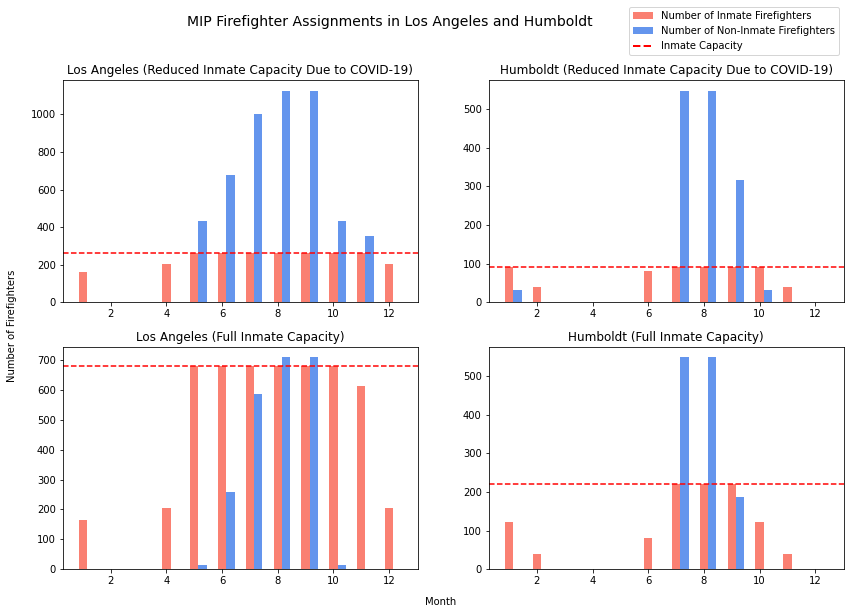

In [118]:
# 3 histograms for 3 different counties (choose a variety of geographies/locations):
#    month on the x-axis, number of firefighters on the y-axis
#    each month has two bars, one for inmates, another for non-inmates

la_data_2020 = all_results_df[(all_results_df['county']=='Los Angeles') & (all_results_df['2020']==1)]
humboldt_data_2020 = all_results_df[(all_results_df['county']=='Humboldt') & (all_results_df['2020']==1)]
la_data = all_results_df[(all_results_df['county']=='Los Angeles') & (all_results_df['2020']==0)]
humboldt_data = all_results_df[(all_results_df['county']=='Humboldt') & (all_results_df['2020']==0)]

fig, axs = plt.subplots(2, 2, figsize=(14, 9))
axs = np.ravel(axs)
months = np.array(la_data_2020['month'])
width = 0.3

la_inmates_2020 = axs[0].bar(months, list(la_data_2020['inmate_num']), width, color='salmon')
axs[0].axhline(y=262, color='red', linestyle='--')
axs[0].set_title('Los Angeles (Reduced Inmate Capacity Due to COVID-19)')
la_non_inmates_2020 = axs[0].bar(months+width, list(la_data_2020['non_inmate_num']), width, color='cornflowerblue')
humboldt_inmates_2020 = axs[1].bar(months, list(humboldt_data_2020['inmate_num']), width, color='salmon')
axs[1].axhline(y=91, color='red', linestyle='--')
humboldt_non_inmates_2020 = axs[1].bar(months+width, list(humboldt_data_2020['non_inmate_num']), width, color='cornflowerblue')
axs[1].set_title('Humboldt (Reduced Inmate Capacity Due to COVID-19)')

la_inmates = axs[2].bar(months, list(la_data['inmate_num']), width, color='salmon')
axs[2].axhline(y=680, color='red', linestyle='--')
axs[2].set_title('Los Angeles (Full Inmate Capacity)')
la_non_inmates = axs[2].bar(months+width, list(la_data['non_inmate_num']), width, color='cornflowerblue')
sacramento_inmates = axs[3].bar(months, list(humboldt_data['inmate_num']), width, color='salmon')
axs[3].axhline(y=220, color='red', linestyle='--')
axs[3].set_title('Humboldt (Full Inmate Capacity)')
sacramento_non_inmates = axs[3].bar(months+width, list(humboldt_data['non_inmate_num']), width, color='cornflowerblue')

fig.text(0.5, 0.07, 'Month', ha='center')
fig.text(0.07, 0.5, 'Number of Firefighters', va='center', rotation='vertical')
fig.suptitle('MIP Firefighter Assignments in Los Angeles and Humboldt', x=0.45, fontsize=14)
legend_elements = [Patch(facecolor='salmon', label='Number of Inmate Firefighters'),
                    Patch(facecolor='cornflowerblue', label='Number of Non-Inmate Firefighters'),
                    Line2D([0], [0], color='red', lw=2, linestyle='--', label='Inmate Capacity')]
fig.legend(handles=legend_elements, bbox_to_anchor=(0.9, 1))

# line plot: x axis - months , y-axis- num firefighters . potentially can plot multiple counties together
# histogram to show estimated additional cost due to lack of inmate firefighters during COVID

In [71]:
# Objective value with inmates: Objective value = $237,866,868.1634739
# Objective value with fewer inmates: Objective value = $263,640,628.1634739

'''
County | Number Inmate/non-inmate firefighters
-----------------------------------------------

County | Month | 2020 (0/1)| Number Inmate Firefighters | Number Non-Inmate Firefighters
----------------------------------------------------------------------------------------
'''

'\nCounty | Number Inmate/non-inmate firefighters\n-----------------------------------------------\n\nCounty | Month | 2020 (0/1)| Number Inmate Firefighters | Number Non-Inmate Firefighters\n----------------------------------------------------------------------------------------\n'